# How to make your Airbnb attractive?  
##### A data-based approach using Seattle Airbnb open data in 2016.

### Background

Airbnb provides us convenient choices when traveling. It connects hosts and travelers by facilitating the process of renting by offering a community-based, two-sided online platform. From the room owners' side, this platform enables them to list their spare space and earn rental money. From the travelers' side, it provides easy access to renting private space during their trips. With its business in more than 34,000 cities and 190 countries, Airbnb offers affordable traveling accommodation options for people worldwide.  

If you have a spare room and are considering gaining benefits from rental on Airbnb, you may want to know how to make your room attractive to people such that they would select your place among all available homes in your neighborhood. In other words, what are the properties of attractive Airbnbs? In this case study, I will perform a simple data analysis on Seattle Airbnb open data in 2016 to get some insights for this question. 

This dataset includes 3818 Airbnb homes in the Seattle area in 2016 distributed in over 17 neighborhoods. It also has 41 variables about the homes (e.g., location, number of rooms, price, review scores) and the hosts (e.g., whether the host is a superhost).

Three subquestions for this study:
1. On average, which areas/neighborhoods have Airbnbs with higher attractiveness?
2. How attractive Airbnbs are different from not-so-attractive Airbnbs?
3. What features are more important for the attractiveness? 

In [1]:
# Import useful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from PIL import Image
import requests
from io import BytesIO

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing

In [2]:
# Set the maximum rows and columns to display
pd.set_option('display.max_rows', 365)
pd.set_option('display.max_columns', 99)

In [3]:
# Read raw data into data variables
# You may change the directory in the quote of the following sentence
seattle_listings = pd.read_csv('.../archive-seattle/listings.csv')

In [4]:
# Now take a look at the dataset - the first five rows
seattle_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [5]:
# ... and also take a look at the non-null counts and data types of each column
seattle_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

### Data pre-processing

In the data pre-processing step, tasks include:
1. remove unnecessary features in the dataset
2. removing/replacing NAs
3. extracting information and changing features into appropriate data types
4. modify classes of some categorical features

A function is created for data pre-processing.

**Notice**: There should be some exploration steps for each feature when deciding whether the feature should be kept and how to fill the NAs. For example, for each feature, I would look at the data type (whether the data type is appropriate and whether there is a need to modify it), the distribution of its values/categories, the missing data rate, possible extreme values or outliers, etc. In this script, these exploration steps are omitted.

Null counts: 647
Describe: count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64
100.0    781
98.0     292
96.0     278
97.0     266
95.0     260
94.0     198
93.0     184
99.0     146
90.0     138
80.0     111
92.0     105
91.0      97
87.0      55
89.0      53
88.0      47
85.0      24
84.0      23
86.0      17
83.0      13
60.0      12
82.0      10
70.0       8
73.0       7
76.0       5
72.0       4
78.0       4
77.0       4
40.0       4
75.0       3
71.0       3
81.0       3
68.0       2
74.0       2
67.0       2
79.0       2
66.0       2
64.0       1
20.0       1
53.0       1
65.0       1
55.0       1
57.0       1
Name: review_scores_rating, dtype: int64


<AxesSubplot:>

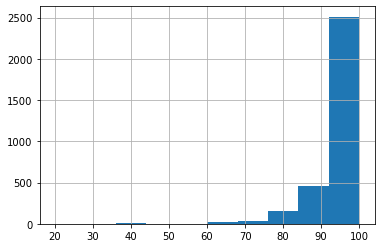

In [6]:
# For example, I could take a look at feature 'review_scores_rating'
print ('Null counts:', seattle_listings['review_scores_rating'].isnull().sum()) 
print ('Describe:', seattle_listings['review_scores_rating'].describe())
print (seattle_listings['review_scores_rating'].value_counts())
seattle_listings['review_scores_rating'].hist()

In [7]:
# Among all the features, I select a few that are likely to be relevant in our analysis
listings_columns = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'description',
                    'neighbourhood_group_cleansed', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 
                    'price', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated', 'availability_365', 'review_scores_rating',
                    'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'reviews_per_month']

seattle_listings = seattle_listings[listings_columns]
seattle_listings.shape
# Now we have 28 features in our dataset

(3818, 29)

In [8]:
# Define a function for data pre-processing
def listings_preprossessing(df):
    '''
    input: the original dataset of listings.csv
    output: processed dataset of listings
            - removing/replacing NAs
            - extracting information and changing features into appropriate data types
            - modify classes of some categorical features
    '''
    
    # Replace text 't' and 'f' to create boolean features
    df.replace('t', True, inplace = True) # T/F
    df.replace('f', False, inplace = True) # T/F
    
    # Extract numbers in 'price' and 'extra_people'
    df.replace({'\$': '', '\%': '', '\,': ''}, regex = True, inplace = True)
    df['price'] = df['price'].str.split('.', expand = True)[0]
    df['extra_people'] = df['extra_people'].str.split('.', expand = True)[0]
    
    # Change data and data type for numerical features
    df[['price', 'extra_people', 'host_response_rate', 'host_acceptance_rate']] = df[['price', 'extra_people', 'host_response_rate', 'host_acceptance_rate']].apply(pd.to_numeric)
    df['host_response_rate'] = df['host_response_rate']/100
    df['host_acceptance_rate'] = df['host_acceptance_rate']/100
    
    # Re-categorize feature 'calendar_updated' and 'property_type', aggregating original categories into new classes
    df['calendar_updated'] = df['calendar_updated'].replace(['today', 'yesterday', '2 days ago'], 'within 3 days')
    df['calendar_updated'] = df['calendar_updated'].replace(['3 days ago', '4 days ago', '5 days ago', '6 days ago'], 'within a week')
    df['calendar_updated'] = df['calendar_updated'].replace(['1 week ago', '2 weeks ago', '3 weeks ago', '4 weeks ago'], 'within a month')
    df['calendar_updated'] = df['calendar_updated'].replace(['5 weeks ago', '6 weeks ago', '7 weeks ago', '2 months ago', '3 months ago', '4 months ago', '5 months ago'], 
                                                            'within half an year')
    df['calendar_updated'] = df['calendar_updated'].replace(['6 months ago', '7 months ago', '8 months ago', '9 months ago', '10 months ago', '11 months ago', '12 months ago', '13 months ago', '14 months ago', '15 months ago', '17 months ago', '22 months ago', '30 months ago'], 
                                                            'more than half an year ago')
    df['property_type'] = df['property_type'].replace(['Bed & Breakfast', 'Boat', 'Bungalow', 'Cabin', 'Camper/RV', 'Chalet', 'Condominium', 'Dorm', 'Loft', 'Other', 'Tent', 'Townhouse', 'Treehouse', 'Yurt'], 'Others')
    
    # Replace NAs
    df['host_response_time'] = df['host_response_time'].fillna('NA') # replace NAs in 'host_response_time' with a string 'NA' to create a new category
    df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].mode()[0]) # replace NAs in 'host_response_rate' with the mode
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0]) # replace NAs in 'bathrooms' with the mode
    df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0]) # replace NAs in 'bedrooms' with the mode
    df['property_type'] = df['property_type'].fillna(df['property_type'].mode()[0]) # replace NAs in 'property_type' with the mode
    df['room_type'] = df['room_type'].fillna(df['room_type'].mode()[0]) # replace NAs in 'room_type' with the mode
    df['bed_type'] = df['bed_type'].fillna(df['bed_type'].mode()[0]) # replace NAs in 'bed_type' with the mode
    df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna(0) # replace NAs in 'host_acceptance_rate' with 0
    df['host_is_superhost'] = df['host_is_superhost'].fillna(0) # replace NAs in 'host_is_superhost' with 0 for a boolean variable
    df['host_has_profile_pic'] = df['host_has_profile_pic'].fillna(0) # replace NAs in 'host_has_profile_pic' with 0 for a boolean variable
    df['host_identity_verified'] = df['host_identity_verified'].fillna(0) # replace NAs in 'host_identity_verified' with 0 for a boolean variable
    
    # Remove rows with NA values
    df.dropna(subset = ['calendar_updated', 'reviews_per_month', 'review_scores_rating'], how = 'any', axis = 0, inplace = True)
            
    # Change T/F features from object to bool
    df['host_is_superhost'] = df['host_is_superhost'] == True
    df['host_has_profile_pic'] = df['host_has_profile_pic'] == True
    df['host_identity_verified'] = df['host_identity_verified'] == True

    return df

In [9]:
# Create a new dataframe for the listings dataset after pre-processing
seattle_listings_clean = listings_preprossessing(seattle_listings)

# Take a look at the detailed information of the new dataframe
seattle_listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 0 to 3814
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                3171 non-null   object 
 1   host_response_rate                3171 non-null   float64
 2   host_acceptance_rate              3171 non-null   float64
 3   host_is_superhost                 3171 non-null   bool   
 4   host_has_profile_pic              3171 non-null   bool   
 5   host_identity_verified            3171 non-null   bool   
 6   description                       3171 non-null   object 
 7   neighbourhood_group_cleansed      3171 non-null   object 
 8   is_location_exact                 3171 non-null   bool   
 9   property_type                     3171 non-null   object 
 10  room_type                         3171 non-null   object 
 11  accommodates                      3171 non-null   int64  
 12  bathro

In [10]:
# Create new columns/features named 'price_per_bed,' 'price_per_accommodate,' 'desc_len.'
seattle_listings_clean['price_per_bed'] = seattle_listings_clean['price'] / seattle_listings_clean['beds']
seattle_listings_clean['price_per_accommodate'] = seattle_listings_clean['price'] / seattle_listings_clean['accommodates']
seattle_listings_clean['desc_len'] = list(map(lambda x: len(x), seattle_listings_clean['description'])) 
seattle_listings_clean.drop(columns = ['description'])

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_365,review_scores_rating,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,price_per_bed,price_per_accommodate,desc_len
0,within a few hours,0.96,1.0,False,True,True,Queen Anne,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,85,2,5,1,365,within a month,346,95.0,False,moderate,False,False,4.07,85.000000,21.250000,987
1,within an hour,0.98,1.0,True,True,True,Queen Anne,True,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,150,1,0,2,90,within 3 days,291,96.0,False,strict,True,True,1.48,150.000000,37.500000,986
2,within a few hours,0.67,1.0,False,True,True,Queen Anne,True,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,975,10,25,4,30,within half an year,220,97.0,False,strict,False,False,1.15,139.285714,88.636364,987
4,within an hour,1.00,0.0,False,True,True,Queen Anne,True,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,450,6,15,1,1125,within half an year,365,92.0,False,strict,False,False,0.89,150.000000,75.000000,981
5,NA,1.00,0.0,False,True,True,Queen Anne,True,House,Private room,2,1.0,1.0,1.0,Real Bed,120,1,30,1,6,within a month,302,95.0,False,strict,False,False,2.45,120.000000,60.000000,993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3810,within an hour,1.00,1.0,False,True,True,Other neighborhoods,True,House,Entire home/apt,5,1.0,2.0,3.0,Real Bed,154,4,50,2,14,within a week,227,92.0,False,strict,False,False,1.56,51.333333,30.800000,977
3811,within a few hours,1.00,1.0,False,True,True,Other neighborhoods,True,Apartment,Entire home/apt,3,1.0,1.0,1.0,Real Bed,65,1,0,1,1125,a week ago,221,100.0,False,moderate,False,False,0.63,65.000000,21.666667,986
3812,within an hour,1.00,1.0,True,True,True,Other neighborhoods,True,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,95,2,8,3,365,within 3 days,287,96.0,True,moderate,True,True,4.01,47.500000,23.750000,990
3813,within a few hours,0.99,1.0,False,True,True,Other neighborhoods,True,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,359,1,0,3,1125,within 3 days,32,80.0,False,strict,False,False,0.30,119.666667,59.833333,985


Notice that in the dataset, the feature "description" has a maximum length of 1000. In other words, descriptions with length longer than 1000 are still counted as 1000.

#### Create the attractiveness indicator - 'attractiveness'

To answer the questions related to attractiveness of Airbnbs, I first need to define the term "attractiveness" of an Airbnn. 

There are two features in the dataset that may be reasonably related to the attractiveness. 

1. "review_scores_rating": the average ratings from guests to an Airbnb place. Higher ratings show higher guest satisfaction. 

2. "reviews_per_month": the numbers of reviews the Airbnb place gets from its guests every month. Here, I make an assumption that the more reviews obtained per month, the more guests this place receives every month. 

The two features represent two dimensions of the "attractiveness": guest satisfaction and guest volume. To integrate the two dimensions into one indicator, I create a new feature "attractiveness" by multiplying the two features:

$$attractiveness = review\_scores\_rating \times reviews\_per\_month$$


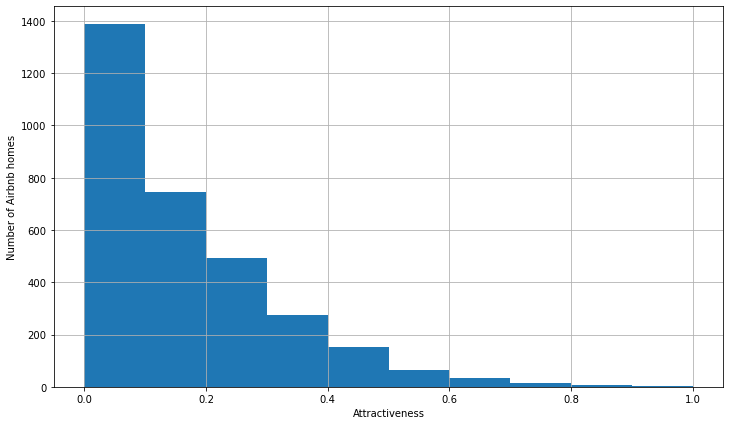

In [11]:
# Create a new column/feature named 'attractiveness'
# Notice both features are normalized into a range of [0, 1]. This is to reduce the impact of different magnitudes of the original features
rating_range = seattle_listings_clean['review_scores_rating'].max() - seattle_listings_clean['review_scores_rating'].min()
review_pm_range = seattle_listings_clean['reviews_per_month'].max() - seattle_listings_clean['reviews_per_month'].min()
seattle_listings_clean['attractiveness'] = ((seattle_listings_clean['review_scores_rating'] - seattle_listings_clean['review_scores_rating'].min())/rating_range) * ((seattle_listings_clean['reviews_per_month'] - seattle_listings_clean['reviews_per_month'].min())/review_pm_range)
seattle_listings_clean['attractiveness'] = (seattle_listings_clean['attractiveness'] - seattle_listings_clean['attractiveness'].min()) / (seattle_listings_clean['attractiveness'].max() - seattle_listings_clean['attractiveness'].min())

# ... and display the histogram
att_hist = seattle_listings_clean['attractiveness'].hist(figsize = (12, 7))
att_hist.set_xlabel("Attractiveness")
att_hist.set_ylabel("Number of Airbnb homes")

# Further drop the two original features from the dataframe
seattle_listings_clean = seattle_listings_clean.drop(columns = ['review_scores_rating', 'reviews_per_month'])

### Question 1: On average, which areas/neighborhoods have Airbnbs with higher attractiveness?

With the indicator "attractiveness" (which is also a new feature in the dataframe now), let's take a look at the average attractiveness in each neighbourhood. 

In [12]:
# Use pandas.DataFrame.groupby() to group the data by 'attractiveness_cat'
neigh_grp = seattle_listings_clean.groupby('neighbourhood_group_cleansed')
pd.DataFrame(neigh_grp['attractiveness'].mean().sort_values(ascending=False))

,attractiveness
neighbourhood_group_cleansed,
Seward Park,0.212598
Ballard,0.212379
Rainier Valley,0.203763
Beacon Hill,0.197627
Downtown,0.190899
Central Area,0.182000
Delridge,0.180937
Queen Anne,0.177627
Interbay,0.165075


We could take a look at the locations of the three neighbourhoods, respectively, on the map.

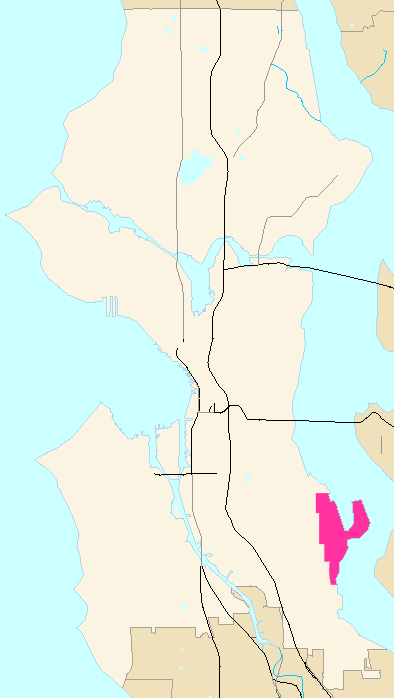

In [13]:
# Seward Park
response = requests.get('https://upload.wikimedia.org/wikipedia/commons/1/1c/Seattle_Map_-_Seward_Park.png?1619218541164')
img = Image.open(BytesIO(response.content))
img

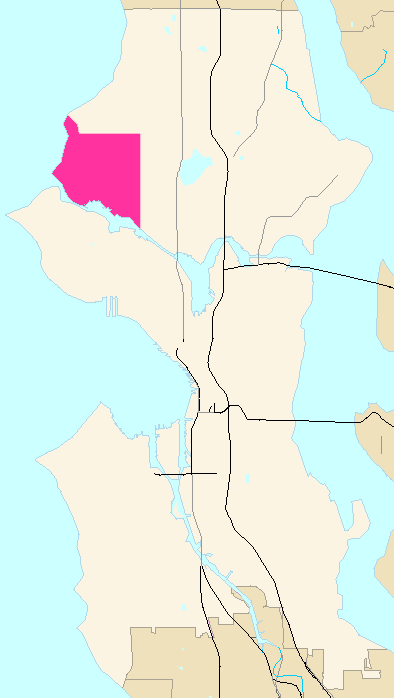

In [14]:
# Ballard
response = requests.get('https://upload.wikimedia.org/wikipedia/commons/a/a1/Seattle_Map_-_Ballard.png?1619218807724')
img = Image.open(BytesIO(response.content))
img

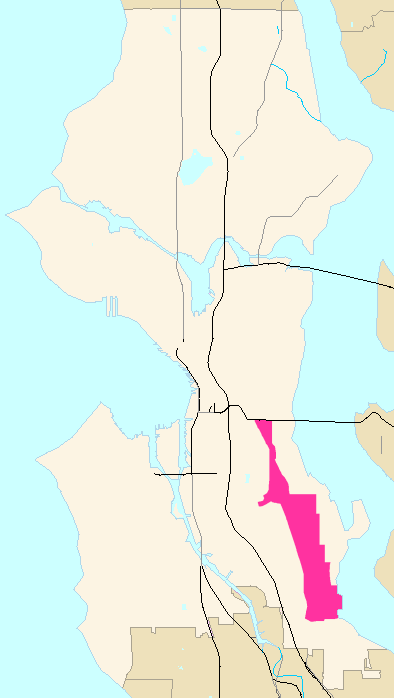

In [15]:
# Rainier Valley
response = requests.get('https://upload.wikimedia.org/wikipedia/commons/d/dd/Seattle_Map_-_Rainier_Valley.png?1619218863709')
img = Image.open(BytesIO(response.content))
img

### Question 2: How attractive Airbnbs are different from not-so-attractive Airbnbs?


In [16]:
# Divide the features into two groups: numerical group, and categorical group
num_columns = seattle_listings_clean.select_dtypes(include=['float64', 'int64', 'bool']).columns
cat_columns = seattle_listings_clean.select_dtypes(include=['object']).columns

### Numerical feature exploration

In [17]:
# Calculate the correlation matrix for numerical features
num_corr = round(seattle_listings_clean[num_columns].corr(), 2)
num_corr

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,availability_365,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,price_per_bed,price_per_accommodate,desc_len,attractiveness
host_response_rate,1.00,-0.07,0.14,0.00,0.06,0.07,-0.01,0.01,-0.00,0.01,-0.02,0.04,-0.00,0.01,-0.02,-0.11,0.08,-0.00,-0.02,-0.02,-0.01,0.08,0.14
host_acceptance_rate,-0.07,1.00,0.13,0.03,0.06,-0.04,0.00,-0.04,-0.08,0.00,-0.15,0.01,-0.02,-0.00,-0.04,0.08,0.10,0.08,0.09,-0.18,-0.22,0.08,0.29
host_is_superhost,0.14,0.13,1.00,0.00,0.12,0.04,-0.03,-0.02,-0.04,-0.04,0.01,0.03,0.02,-0.01,-0.03,-0.03,0.07,0.08,0.09,0.07,0.05,0.10,0.29
host_has_profile_pic,0.00,0.03,0.00,1.00,0.08,-0.01,-0.00,-0.00,0.00,0.01,-0.02,0.00,-0.02,0.00,-0.00,0.01,-0.00,0.01,0.01,-0.03,-0.01,0.01,0.02
host_identity_verified,0.06,0.06,0.12,0.08,1.00,0.04,0.04,-0.02,-0.02,0.01,0.01,0.03,0.04,-0.03,-0.01,-0.02,-0.02,0.10,0.12,0.00,-0.01,0.12,0.08
is_location_exact,0.07,-0.04,0.04,-0.01,0.04,1.00,-0.00,0.02,0.02,0.01,0.01,0.07,0.06,0.01,-0.01,-0.03,0.02,-0.05,-0.03,0.01,0.03,0.10,-0.00
accommodates,-0.01,0.00,-0.03,-0.00,0.04,-0.00,1.00,0.53,0.77,0.86,0.65,0.54,0.14,0.02,0.01,-0.03,0.03,0.05,0.06,-0.10,-0.25,0.07,-0.14
bathrooms,0.01,-0.04,-0.02,-0.00,-0.02,0.02,0.53,1.00,0.61,0.53,0.51,0.30,0.07,0.00,-0.01,-0.01,-0.05,0.03,0.02,-0.01,0.03,-0.00,-0.16
bedrooms,-0.00,-0.08,-0.04,0.00,-0.02,0.02,0.77,0.61,1.00,0.75,0.63,0.47,0.10,0.01,-0.01,-0.05,-0.06,0.02,0.02,-0.09,-0.07,0.02,-0.23
beds,0.01,0.00,-0.04,0.01,0.01,0.01,0.86,0.53,0.75,1.00,0.58,0.48,0.13,-0.00,-0.01,-0.00,0.03,0.04,0.05,-0.27,-0.18,0.05,-0.15


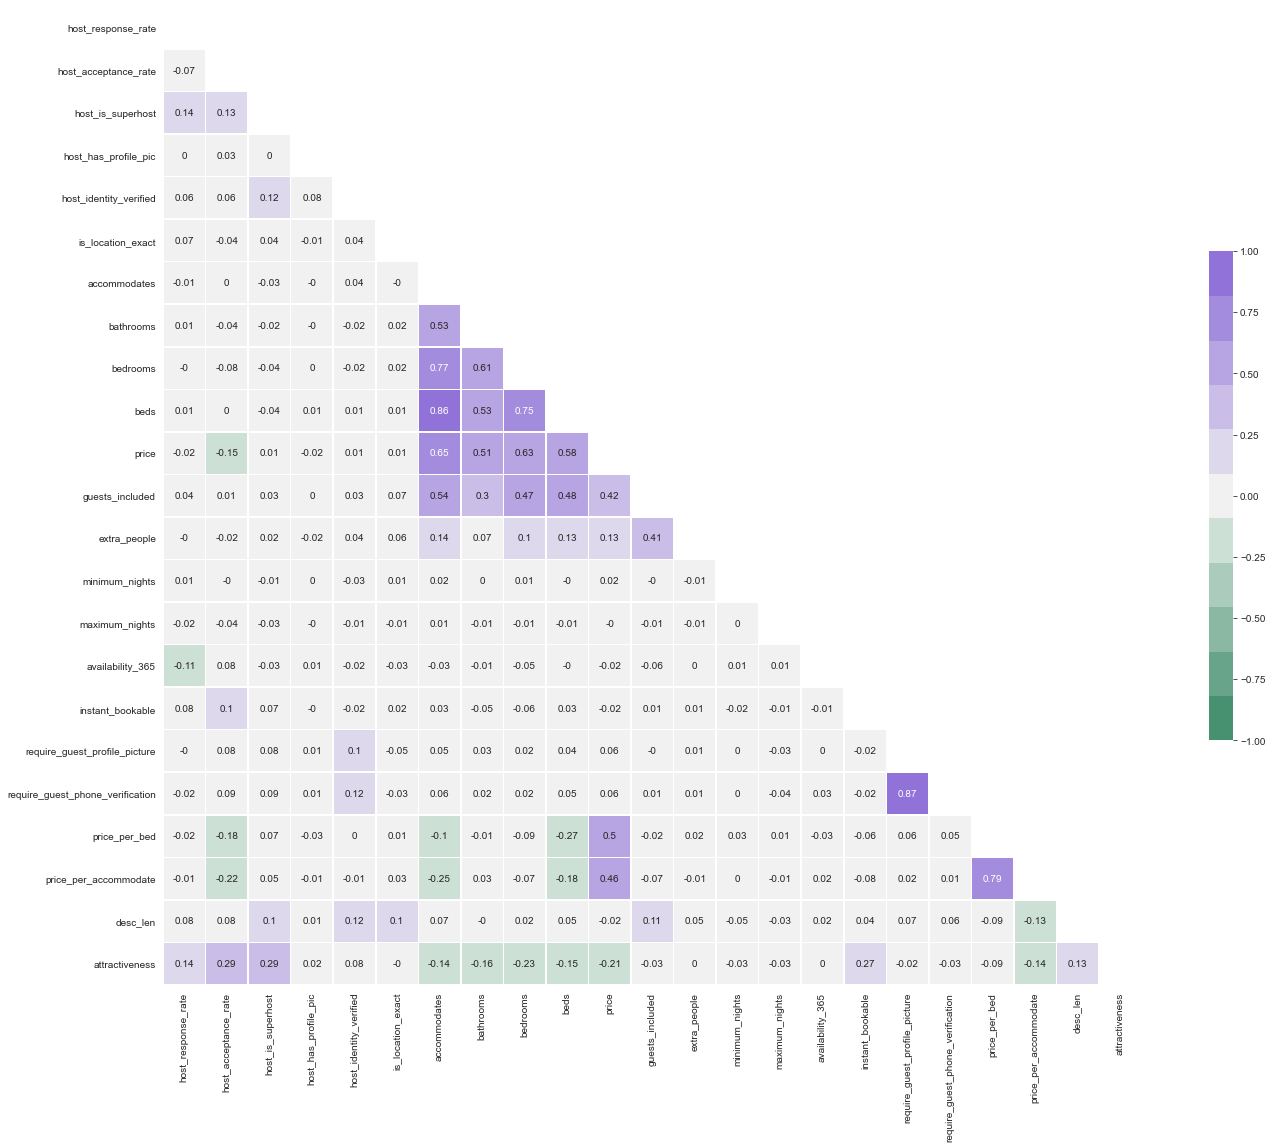

In [18]:
# Let's further visualize the correlation matrix 
# Acknowledgement: The codes of the following function is credited to vestland (https://stackoverflow.com/users/3437787/vestland), who wrote an answer at https://stackoverflow.com/a/48278285/14816853. 
def CorrMtx(df_corr, dropDuplicates = True):
    
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df_corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(24, 18))
#    plt.rcParams.update({'font.size': 14})

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(150, 275, s=70, l=55, n=11)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df_corr, mask=mask, cmap=cmap, 
                    vmin=-1.0, vmax=1.0,
                    square=True, annot = True,
                    linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df_corr, cmap=cmap, 
                    vmin=-1.0, vmax=1.0,
                    square=True, annot = True,
                    linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

CorrMtx(num_corr, dropDuplicates = True)

##### Create a new categorical feature - 'attractiveness_cat'

From the histogram we generated in one of the previous cells, we could see that the new feature "attractiveness" is also in the range [0, 1].  
It could also be observed that the distribution of the 'attractiveness' is right-skewed. To further explore what makes Airbnb attractive, I categorized the whole dataset into three groups: "High" attractiveness group, "Medium" attractiveness group, and "Low" attractiveness group. The groups are divided based on the quantiles of "attractiveness."

In [19]:
# Take a look at the quantiles of 'attractiveness'
pd.DataFrame(seattle_listings_clean['attractiveness'].describe())

,attractiveness
count,3171.000000
mean,0.170736
std,0.151793
min,0.000000
25%,0.054466
50%,0.126145
75%,0.248640
max,1.000000


In [20]:
# Create a categorical feature 'attractiveness_cat'
# 1. High: 'attrativeness' >= 0.233100 (75% quantile)
# 2. Medium: 0.051061 (25% quantile) < 'attractiveness' < 0.233100 (75% quantile)
# 3. Low: 'attractiveness' <= 0.051061 (25% quantile)

def cat_attractiveness(attractiveness):
    if attractiveness >= seattle_listings_clean['attractiveness'].describe()['75%']:
        return ('High')
    elif attractiveness > seattle_listings_clean['attractiveness'].describe()['25%']:
        return ('Medium')
    else:
        return ('Low')

seattle_listings_clean['attractiveness_cat'] = list(map(lambda x: cat_attractiveness(x), seattle_listings_clean['attractiveness']))

In the correlation matrix, several features have comparatively high correlation with feature "attractiveness." For instance, "host_response_rate" (0.14), "host_acceptance_rate" (0.29), "host_is_superhost" (0.29),   
Let's take a look at how the mean values of the numerical features differ for different attractiveness groups.

In [21]:
# Get the features that have correlations (absolute value) larger than 0.15
filt = abs(num_corr['attractiveness']) >= 0.1
num_columns_highcor = num_corr[filt].index

# Use pandas.DataFrame.groupby() to group the data by 'attractiveness_cat'
attractiveness_grp = seattle_listings_clean.groupby('attractiveness_cat')
attractiveness_grp[num_columns_highcor].agg(['mean']).loc[['High', 'Medium', 'Low'], :]

,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,bathrooms,bedrooms,beds,price,instant_bookable,price_per_accommodate,desc_len,attractiveness
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
attractiveness_cat,,,,,,,,,,,,
High,0.979484,0.984887,0.421914,2.964736,1.114610,1.026448,1.473552,98.788413,0.317380,36.424988,934.472292,0.386649
Medium,0.954792,0.879419,0.227273,3.429293,1.274621,1.320076,1.774621,127.962753,0.147727,39.810716,903.456439,0.133636
Low,0.938625,0.653216,0.070618,3.715006,1.368222,1.542245,1.947037,152.534678,0.068096,45.268666,859.644388,0.028656


We could visualize the two boolean variables for High-attractiveness group and Low-attractiveness group.

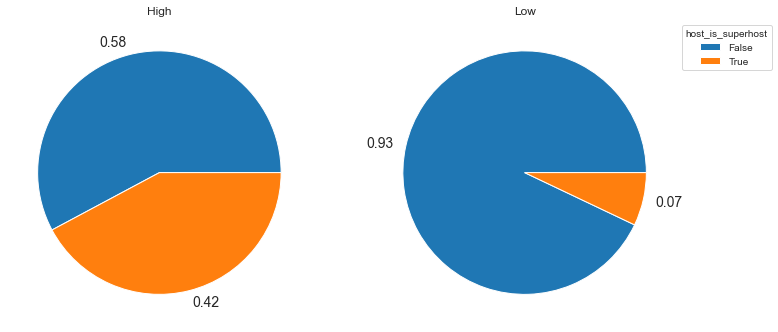

In [22]:
# Draw a pie plot for feature 'host_is_superhost'
Nattr_class = 2
fig, axs = plt.subplots(1, Nattr_class, figsize=(6*Nattr_class,6), subplot_kw={'aspect':'equal'})
for ax,(groupname,subdf) in zip(axs, attractiveness_grp):
    ax.pie(subdf['host_is_superhost'].value_counts(), labels=round(subdf['host_is_superhost'].value_counts()/subdf['host_is_superhost'].count(), 2), textprops={'fontsize': 14})
    ax.set_title(groupname)
plt.legend(subdf['host_is_superhost'].unique(), title = "host_is_superhost", loc="best", bbox_to_anchor=(1, 1))

# From the pie charts below we could see that in the High-attractiveness group, about 42% of the hosts are superhosts, while in the Low-attractiveness group, this percentage is 7%. 

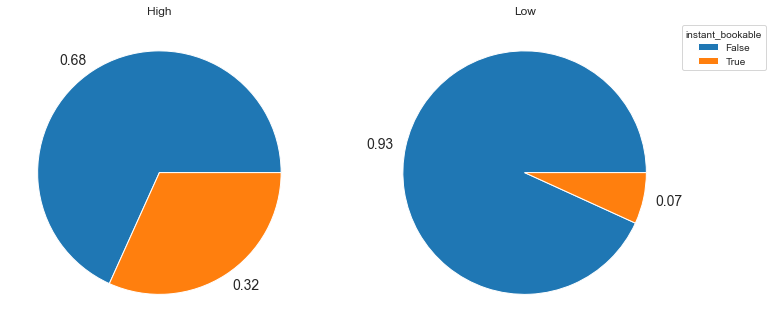

In [23]:
# Draw a pie plot for feature 'instant_bookable'
Nattr_class = 2
fig, axs = plt.subplots(1, Nattr_class, figsize=(6*Nattr_class,6), subplot_kw={'aspect':'equal'})
for ax,(groupname,subdf) in zip(axs, attractiveness_grp):
    ax.pie(subdf['instant_bookable'].value_counts(), labels=round(subdf['instant_bookable'].value_counts()/subdf['instant_bookable'].count(), 2), textprops={'fontsize': 14})
    ax.set_title(groupname)
plt.legend(subdf['instant_bookable'].unique(), title = "instant_bookable", loc="best", bbox_to_anchor=(1, 1))

# From the pie charts below we could see that in the High-attractiveness group, about 32% of the homes are instant bookable, while in the Low-attractiveness group, this percentage is 7%. 

We then run some statistical tests to see whether there are statistically significantly differences among the three attractiveness groups for each feature we obtain from the correlation matrix.  
Since the features are not normally distributed, it might not be appropriate to use Student t-test or Welch’s t-test to compare the groups. In this study, we use ANOVA tests [[3]](https://www.scribbr.com/statistics/one-way-anova/).

In [24]:
# Feature 'price_per_accommodate'
high = seattle_listings_clean[seattle_listings_clean['attractiveness_cat'] == 'High']['price_per_accommodate']
low = seattle_listings_clean[seattle_listings_clean['attractiveness_cat'] == 'Low']['price_per_accommodate']
medium = seattle_listings_clean[seattle_listings_clean['attractiveness_cat'] == 'Medium']['price_per_accommodate']
fvalue, pvalue = stats.f_oneway(high, low, medium)
print ("ANOVA test for 'price_per_accommodate' --", "F-value:", fvalue, "p-value:", pvalue)

ANOVA test for 'price_per_accommodate' -- F-value: 41.97943215461134 p-value: 1.0138302487072095e-18


For feature "price_per_accommodate", the p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among three attractiveness groups.  
In the following, I will do the same thing to features "host_response_rate," "host_acceptance_rate," "host_is_superhost," "accommodates," "bathrooms," "bedrooms," "beds," "price," and "instant_bookable."

In [25]:
feature_list_anova = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'accommodates', 'bathrooms', 'bedrooms', 
                      'beds', 'price', 'instant_bookable', 
                     # 'desc_len'
                     ]
for ft_loop in feature_list_anova:
    high = seattle_listings_clean[seattle_listings_clean['attractiveness_cat'] == 'High'][ft_loop]
    low = seattle_listings_clean[seattle_listings_clean['attractiveness_cat'] == 'Low'][ft_loop]
    medium = seattle_listings_clean[seattle_listings_clean['attractiveness_cat'] == 'Medium'][ft_loop]
    fvalue, pvalue = stats.f_oneway(high, low, medium)
    print ("ANOVA test for", ft_loop, " -- F-value:", fvalue, "p-value:", pvalue)

ANOVA test for host_response_rate  -- F-value: 29.498639707034613 p-value: 2.026434955377864e-13
ANOVA test for host_acceptance_rate  -- F-value: 205.033702381788 p-value: 1.838492608698934e-84
ANOVA test for host_is_superhost  -- F-value: 148.9160483351539 p-value: 1.5438433948949216e-62
ANOVA test for accommodates  -- F-value: 29.47929503937296 p-value: 2.0652869672606751e-13
ANOVA test for bathrooms  -- F-value: 38.357181725174954 p-value: 3.468832831120968e-17
ANOVA test for bedrooms  -- F-value: 72.95354913528011 p-value: 1.058357301154293e-31
ANOVA test for beds  -- F-value: 35.32456376355604 p-value: 6.718884049013844e-16
ANOVA test for price  -- F-value: 74.2794870148003 p-value: 2.9809780517748585e-32
ANOVA test for instant_bookable  -- F-value: 98.64663417980405 p-value: 2.7505130650920574e-42


The p-values reveal that the three attractiveness groups have statistically different values for all features of "host_response_rate," "host_acceptance_rate," "host_is_superhost," "accommodates," "bathrooms," "bedrooms," "beds," "price," "instant_bookable, "price_per_accommodate." 

Several observations we could obtain by analyzing numerical features:
1. "host_acceptance_rate": Acceptance rate measures how often the host accepts or rejects reservations. The High-attractiveness group has a significantly higher acceptance rate (0.98) than the Low-attractiveness group (0.65).
2. "host_response_rate": Hosts in the High-attractiveness group have a higher response rate (0.98) than those in the Low-attractiveness group (0.94). 
3. "host_is_superhost": This boolean feature tells whether the host is a superhost or not, and the mean of this feature represents the percentage of superhost in each attractiveness group. We could notice that the High-attractiveness group has a significantly higher percentage of superhost (0.42 vs. 0.07) (see Figure 3 for pie chart). 
4. "instant_bookable": Instant book listings allow guests to book immediately without needing to send a reservation request to the host for approval, and the mean of this feature represents the percentages of homes that are instantly bookable in each attractiveness group. The High-attractiveness group has significantly more homes that are instantly bookable (percentages of 0.32 vs. 0.07) (see Figure 4 for pie chart).
5. "price," "bathrooms," "bedrooms," and "beds": These variables indicate the price, number of bathrooms, number of bedrooms, and number of beds in a home. It shows that homes in the High-attractiveness group have fewer bathrooms/bedrooms/beds and lower prices comparing with homes in the Low-attractiveness group. From the correlation matrix, we could also notice that these variables have very high correlations with each other (which is reasonable since bigger homes with more rooms or beds may lead to higher prices). In general, we may feel that lower price homes, i.e., economical homes, are more attractive than luxury places for most people and ordinary trips.
6. "accommodates" and "price_per_accommodate": The data reveals that Airbnbs in the High-attractiveness group have fewer accommodates and lower price per accommodate, comparing with Airbnbs in the Low-attractiveness group. 
7. "desc_len": This variable describes how long the description of an Airbnb home is on the website. High-attractiveness groups tend to have longer descriptions of their homes, while Low-attractiveness homes have shorter ones.

### Categorical feature exploration

Then we could take a look at the categorical features. For each categorical feature, there are finite classes. I'm interested in whether the proportions of each class are different for High-attractiveness and Low-attractiveness groups.

For each feature, there are two steps in this process:
1. Calculate the percentages of each class for the two attractiveness groups (High and Low), respectively
2. Look at the calculated results for each feature, and select features with significant differences.
3. Arrange the data in a format that can be used for visualization. Here I use seaborn.catplot to present the results.

In [26]:
# For each feature, calculate the percentages of each class for two attractiveness groups respectively
attr_groups = ['High', 'Low']
host_response_time_pct = pd.DataFrame(0, index = seattle_listings_clean['host_response_time'].unique(), columns = attr_groups)
neighbourhood_group_cleansed_pct = pd.DataFrame(0, index = seattle_listings_clean['neighbourhood_group_cleansed'].unique(), columns = attr_groups)
calendar_updated_pct = pd.DataFrame(0, index = seattle_listings_clean['calendar_updated'].unique(), columns = attr_groups)
cancellation_policy_pct = pd.DataFrame(0, index = seattle_listings_clean['cancellation_policy'].unique(), columns = attr_groups)
property_type_pct = pd.DataFrame(0, index = seattle_listings_clean['property_type'].unique(), columns = attr_groups)
room_type_pct = pd.DataFrame(0, index = seattle_listings_clean['room_type'].unique(), columns = attr_groups)
bed_type_pct = pd.DataFrame(0, index = seattle_listings_clean['bed_type'].unique(), columns = attr_groups)

for group_i in attr_groups:
    filt = seattle_listings_clean['attractiveness_cat'] == group_i
    host_response_time_pct.loc[seattle_listings_clean.loc[filt, 'host_response_time'].value_counts().index, group_i] = seattle_listings_clean.loc[filt, 'host_response_time'].value_counts()/seattle_listings_clean[filt].shape[0]
    neighbourhood_group_cleansed_pct.loc[seattle_listings_clean.loc[filt, 'neighbourhood_group_cleansed'].value_counts().index, group_i] = seattle_listings_clean.loc[filt, 'neighbourhood_group_cleansed'].value_counts()/seattle_listings_clean[filt].shape[0]
    calendar_updated_pct.loc[seattle_listings_clean.loc[filt, 'calendar_updated'].value_counts().index, group_i] = seattle_listings_clean.loc[filt, 'calendar_updated'].value_counts()/seattle_listings_clean[filt].shape[0]
    cancellation_policy_pct.loc[seattle_listings_clean.loc[filt, 'cancellation_policy'].value_counts().index, group_i] = seattle_listings_clean.loc[filt, 'cancellation_policy'].value_counts()/seattle_listings_clean[filt].shape[0]
    property_type_pct.loc[seattle_listings_clean.loc[filt, 'property_type'].value_counts().index, group_i] = seattle_listings_clean.loc[filt, 'property_type'].value_counts()/seattle_listings_clean[filt].shape[0]
    room_type_pct.loc[seattle_listings_clean.loc[filt, 'room_type'].value_counts().index, group_i] = seattle_listings_clean.loc[filt, 'room_type'].value_counts()/seattle_listings_clean[filt].shape[0]
    bed_type_pct.loc[seattle_listings_clean.loc[filt, 'bed_type'].value_counts().index, group_i] = seattle_listings_clean.loc[filt, 'bed_type'].value_counts()/seattle_listings_clean[filt].shape[0]
    

From the results we could see that the two attractiveness groups have observable differences in "host_response_time," "calendar_updated," and "cancellation_policy."  

Re-formulate the data and visualize the results.

                        High       Low
within a few hours  0.197733  0.295082
within an hour      0.740554  0.252207
NA                  0.011335  0.238335
within a day        0.050378  0.196721
a few days or more  0.000000  0.017654


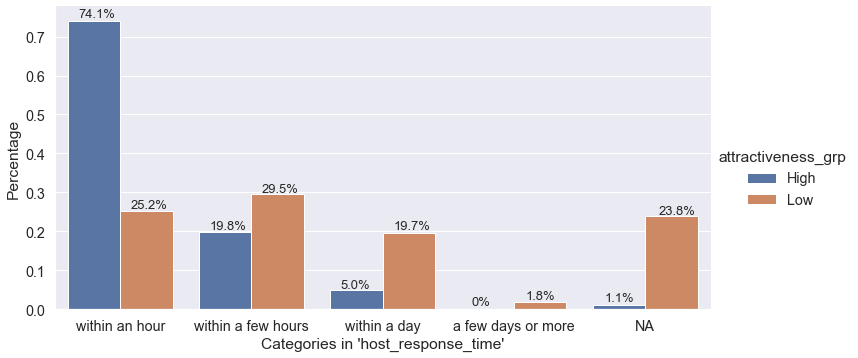

In [27]:
# Feature 'host_response_time'
host_resp_vistb = pd.DataFrame(columns = ['feature', 'attractiveness_grp', 'feature_class', 'pct'])
index_list = ['within an hour', 'within a few hours', 'within a day', 'a few days or more', 'NA']
for index_loop in index_list:
    for attr_grp_loop in host_response_time_pct.columns:
        host_resp_vistb = host_resp_vistb.append({'feature': 'host_response_time', 
                             'attractiveness_grp': attr_grp_loop, 
                             'feature_class': index_loop, 
                             'pct': host_response_time_pct.loc[index_loop, attr_grp_loop]}, ignore_index = True)
        
sns.set_style('whitegrid')
sns.set(font_scale=1.3) 
host_resp_vis = sns.catplot(x='feature_class', y='pct', hue='attractiveness_grp', data=host_resp_vistb, kind='bar', height=5, aspect=2)
host_resp_vis.ax.text(-0.32, 0.75, '74.1%', size = 13)
host_resp_vis.ax.text(0.08, 0.26, '25.2%', size = 13)
host_resp_vis.ax.text(0.68, 0.205, '19.8%', size = 13)
host_resp_vis.ax.text(1.08, 0.30, '29.5%', size = 13)
host_resp_vis.ax.text(1.68, 0.055, '5.0%', size = 13)
host_resp_vis.ax.text(2.08, 0.205, '19.7%', size = 13)
host_resp_vis.ax.text(2.68, 0.01, '0%', size = 13)
host_resp_vis.ax.text(3.09, 0.025, '1.8%', size = 13)
host_resp_vis.ax.text(3.69, 0.02, '1.1%', size = 13)
host_resp_vis.ax.text(4.1, 0.245, '23.8%', size = 13)
palette = sns.color_palette("pastel")
host_resp_vis.set(xlabel="Categories in 'host_response_time'", ylabel = "Percentage")
print (host_response_time_pct)

                                High       Low
within a month              0.224181  0.204288
within 3 days               0.413098  0.209332
within half an year         0.090680  0.416141
a week ago                  0.085642  0.037831
within a week               0.185139  0.059269
more than half an year ago  0.001259  0.070618
never                       0.000000  0.002522


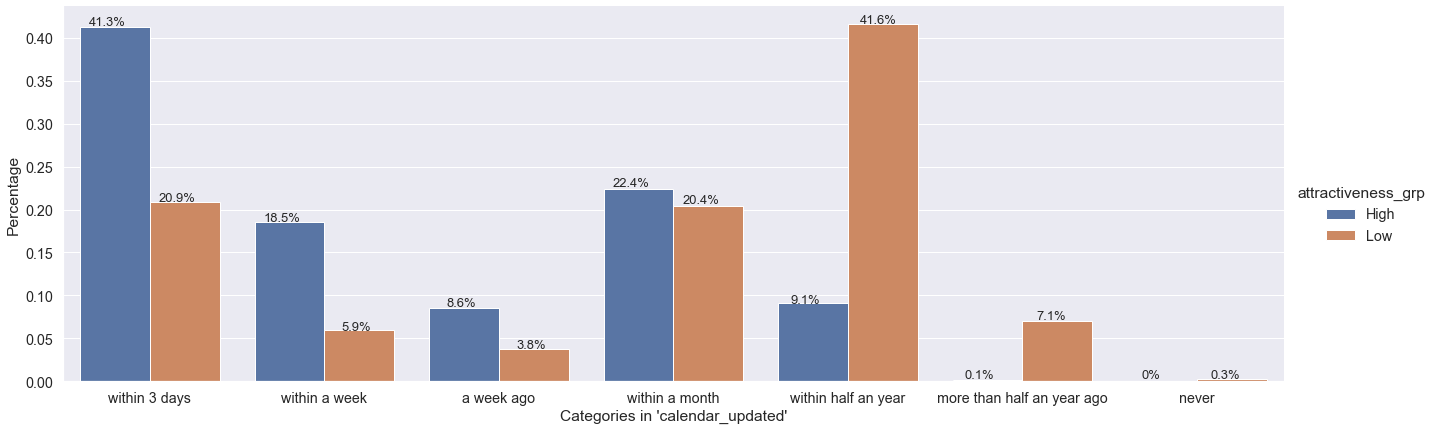

In [28]:
# Feature 'calendar_updated'
calendar_vistb = pd.DataFrame(columns = ['feature', 'attractiveness_grp', 'feature_class', 'pct'])
index_list = ['within 3 days', 'within a week', 'a week ago', 'within a month', 'within half an year', 'more than half an year ago', 'never']
for index_loop in index_list:
    for attr_grp_loop in calendar_updated_pct.columns:
        calendar_vistb = calendar_vistb.append({'feature': 'calendar_updated', 
                             'attractiveness_grp': attr_grp_loop, 
                             'feature_class': index_loop, 
                             'pct': calendar_updated_pct.loc[index_loop, attr_grp_loop]}, ignore_index = True)

sns.set_style('whitegrid')
sns.set(font_scale=1.3) 
calendar_vis = sns.catplot(x='feature_class', y='pct', hue='attractiveness_grp', data=calendar_vistb, kind='bar', height=6, aspect=3)
palette = sns.color_palette("pastel")
calendar_vis.ax.text(-0.35, 0.415, '41.3%', size = 13)
calendar_vis.ax.text(0.05, 0.21, '20.9%', size = 13)
calendar_vis.ax.text(0.65, 0.187, '18.5%', size = 13)
calendar_vis.ax.text(1.1, 0.060, '5.9%', size = 13)
calendar_vis.ax.text(1.7, 0.087, '8.6%', size = 13)
calendar_vis.ax.text(2.1, 0.039, '3.8%', size = 13)
calendar_vis.ax.text(2.65, 0.227, '22.4%', size = 13)
calendar_vis.ax.text(3.05, 0.207, '20.4%', size = 13)
calendar_vis.ax.text(3.67, 0.091, '9.1%', size = 13)
calendar_vis.ax.text(4.07, 0.417, '41.6%', size = 13)
calendar_vis.ax.text(4.67, 0.003, '0.1%', size = 13)
calendar_vis.ax.text(5.08, 0.072, '7.1%', size = 13)
calendar_vis.ax.text(5.68, 0.003, '0%', size = 13)
calendar_vis.ax.text(6.08, 0.004, '0.3%', size = 13)
calendar_vis.set(xlabel="Categories in 'calendar_updated'", ylabel = "Percentage")
print (calendar_updated_pct)

              High       Low
moderate  0.434509  0.302648
strict    0.355164  0.466583
flexible  0.210327  0.230769


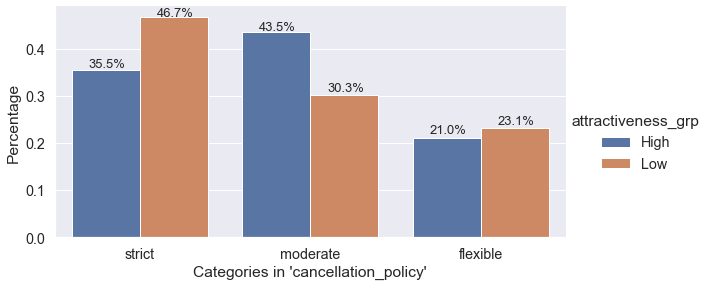

In [29]:
# Feature 'cancellation_policy'
cancel_vistb = pd.DataFrame(columns = ['feature', 'attractiveness_grp', 'feature_class', 'pct'])
index_list = ['strict', 'moderate', 'flexible']
for index_loop in index_list:
    for attr_grp_loop in cancellation_policy_pct.columns:
        cancel_vistb = cancel_vistb.append({'feature': 'cancellation_policy', 
                             'attractiveness_grp': attr_grp_loop, 
                             'feature_class': index_loop, 
                             'pct': cancellation_policy_pct.loc[index_loop, attr_grp_loop]}, ignore_index = True)

sns.set_style('whitegrid')
sns.set(font_scale=1.3) 
cancel_vis = sns.catplot(x='feature_class', y='pct', hue='attractiveness_grp', data=cancel_vistb, kind='bar', height=4, aspect=2)
palette = sns.color_palette("pastel")
cancel_vis.ax.text(-0.3, 0.36, '35.5%', size = 13)
cancel_vis.ax.text(0.1, 0.47, '46.7%', size = 13)
cancel_vis.ax.text(0.7, 0.44, '43.5%', size = 13)
cancel_vis.ax.text(1.1, 0.31, '30.3%', size = 13)
cancel_vis.ax.text(1.7, 0.22, '21.0%', size = 13)
cancel_vis.ax.text(2.1, 0.24, '23.1%', size = 13)
cancel_vis.set(xlabel="Categories in 'cancellation_policy'", ylabel = "Percentage")
print (cancellation_policy_pct)

Observations we could obtain by analyzing categorical features:
1. "host_response_time": About 3/4 (74.1%) of the hosts in the High-attractiveness group respond to reservation requests within an hour, and 93.9% of the hosts respond within a few hours. In the Low-attractiveness group, the two numbers are 25.2% and 54.7% respectively. Hosts in the High-attractiveness group tend to respond timely.
2. "calendar_updated": About 41.3% of the hosts in the High-attractiveness group update their calendars within three days, and about 59.8% do that within a week. In the Low-attractiveness group, the percentages are 20.9% and 26.8%, respectively. Hosts in the High-attractiveness group tend to frequently update their calendars to provide more accurate information on availability and booking.
3. "cancellation_policy": For cancellation policy, though the percentages of flexible cancellation for the High-attractiveness group and Low-attractiveness group do not differ significantly, the High-attractiveness group seems to have more homes with "moderate" cancellation policy and fewer with "strict" cancellation policy. 

### Question 3: What features are more important for the attractiveness? 

With the above analysis, we find several numerical and categorical features that can be closely related to different attractiveness groups. However, it is still not very clear how important each of the feature is. In this question, I use a **random forest classification model** to classify and predict the attractiveness groups, i.e., feature “attractiveness_cat." Feature importance is also obtained with the model. Here I use Permutation importance, which is a common, reasonably efficient, and very reliable technique [[2]](https://explained.ai/rf-importance/). 

In [30]:
# Label Encoder: converting the labels in categorical features into numeric form, so as to convert it into the machine-readable form.
# Here I create three new features for 'host_response_time', 'calendar_updated', and 'cancellation_policy'
host_resp_time_le = preprocessing.LabelEncoder()
seattle_listings_clean['host_response_time_cat'] = host_resp_time_le.fit_transform(seattle_listings_clean['host_response_time'])
calendar_update_le = preprocessing.LabelEncoder()
seattle_listings_clean['calendar_updated_cat'] = calendar_update_le.fit_transform(seattle_listings_clean['calendar_updated'])
cancel_le = preprocessing.LabelEncoder()
seattle_listings_clean['cancellation_policy_cat'] = cancel_le.fit_transform(seattle_listings_clean['cancellation_policy'])


In [31]:
# Define the dependent variable and independent variables
y = seattle_listings_clean['attractiveness_cat']
feature_list = ['host_response_rate', 'host_acceptance_rate', 'accommodates',
                'instant_bookable', 'price_per_accommodate', 'price',
                'host_is_superhost', 
                'host_response_time_cat', 'calendar_updated_cat', 'cancellation_policy_cat']
X = seattle_listings_clean[feature_list]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the model
rf = RandomForestClassifier(n_jobs=-1, random_state=42, min_samples_leaf=8)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
prediction = rf.predict(X_test)

# Check prediction accuracy
accuracy = metrics.accuracy_score(y_test, prediction)
print(accuracy)

0.5798319327731093


Feature: 0, Score: 0.02524
Feature: 1, Score: 0.05345
Feature: 2, Score: 0.03010
Feature: 3, Score: 0.02533
Feature: 4, Score: 0.05633
Feature: 5, Score: 0.07544
Feature: 6, Score: 0.07463
Feature: 7, Score: 0.07832
Feature: 8, Score: 0.06129
Feature: 9, Score: 0.02614


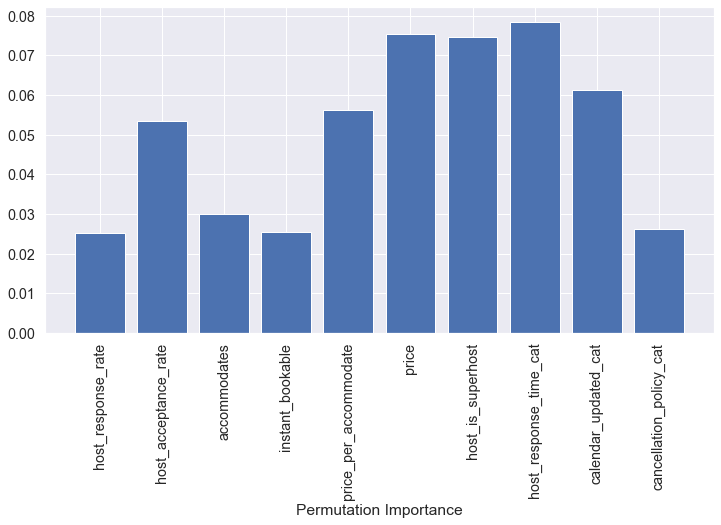

In [32]:
# get importance
per_inp = permutation_importance(rf, X_train, y_train)
importance = per_inp.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.rcParams.update({'figure.figsize': (12.0, 6.0)})
plt.rcParams.update({'font.size': 14})
plt.bar(feature_list, per_inp.importances_mean)
plt.xticks(rotation='vertical')
plt.xlabel('Permutation Importance')
plt.show()

From the figure above it could be observed that features have importance larger than 0.05 include "host_response_time_cat," "host_is_superhost," "price," "price_per_accommodate," "calendar_updated_cat," and "host_acceptance_rate."

### Conclusion

In this case study, I'm trying to explore the attractiveness of Airbnbs in Seattle. On average, we could see that among all the neighborhoods in Seattle, Seward Park, Ballard, and Rainier Valley seem to be more popular than Airbnb homes in other neighborhoods.

If you want to be an attractive Airbnb host, there are several possible suggestions:

1. Don't always reject guests' reservations.  
The High-attractiveness group has a significantly higher acceptance rate (0.98) than the Low-attractiveness group (0.65). Thus, consider being more hospitable and accepting more reservations.

2. Make your place instantly bookable.  
About 1/3 (0.32) of the hosts in the High-attractiveness group choose to make their homes instantly bookable, while in the Low-attractiveness group, the value is only 0.07. "Instantly bookable" means the guests could book a home immediately without needing to send a reservation request to the host for approval. Consider providing this type of convenience to your guests to increase the attractiveness of your Airbnb.

3. Respond to a reservation request as soon as possible.  
In the High-attractiveness group, about 3/4 (74.1%) of the hosts respond to reservation requests within an hour, and 93.9% of the hosts can send out their responses within a few hours. Yet, in the Low-attractiveness group, the two numbers are 25.2% and 54.7% respectively. Timely responses are recommended, as they show that you are likely to be hospitable, attentive and considerate, thus increase the attractiveness.

4. Update your calendar frequently.  
In the High-attractiveness group, about 41.3% of the hosts update their calendars within three days, and about 59.8% do that within a week. In the Low-attractiveness group, the percentages are 20.9% and 26.8%, respectively. Frequently updating the calendars will provide more accurate information on availability and booking. This may also reduce the probability that you have to reject reservations because of unavailability or incorrect information.

5. Avoid being too strict on the cancellation policy.  
Nearly 1/2 (46.7%) of the Airbnbs in the Low-attractiveness group have a strict cancellation policy, while for the higher-attractiveness group, this proportion is about 1/3 (35.5%). Given some degrees of flexibility in the cancellation policy may be attractive for people who still have some concerns when booking home for trips.

6. Provide more description of your home.  
The High-attractiveness groups are shown to have longer descriptions of their homes, comparing with the Low-attractiveness groups. Usually, a longer and more specific description of your home may provide more details that travelers may care about and concern about.

7. Get recognized as a superhost.  
In the High-attractiveness group, about 42% of the hosts are superhosts, while in the Low-attractiveness group, this percentage is only 7%. This indicates that a recognized superhost is more likely related to attractive Airbnbs, and success in the business. Indeed, being recognized as a superhost means that you are already working perfectly in pervious aspects.

8. 1b1b rooms with one or two beds and lower prices might be promising.  
An interesting finding is that homes in the High-attractiveness group have fewer bathrooms/bedrooms/beds and lower prices than homes in the Low-attractiveness group. It is possible because that people who choose Airbnbs would prefer economical accommodations. Thus, homes with just-right size, number of rooms/beds, and price would be popular. In other words, 1b1b (1 bedroom 1 bathroom) with economical price can be promising in the market.

When making predictions on whether an Airbnb is attractive or not, the most important features I would take a look at are the price (including the price and the price divided by the number of accommodates), how quickly the host responds to a request, whether the host is a superhost, the calender updated frequency, and how likely the host accepts reservation requests from guests.